In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdMolAlign
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import rdForceFieldHelpers

from rdkit.Chem import PyMol
import copy
import numpy as np

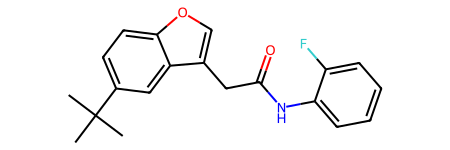

In [4]:
m_full = Chem.MolFromSmiles("CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1")
m_full

In [7]:
frags = Chem.MolFromSmiles("CC(C)(C)c1ccc2occ([*:2])c2c1.Fc1ccccc1[*:1]")
linker = Chem.MolFromSmiles("O=C(C[*:2])N[*:1]")
# Include dummy atoms in query
du = Chem.MolFromSmiles('*')
qp = Chem.AdjustQueryParameters()
qp.makeDummiesQueries=True
# Get matches to fragments and linker
qfrag = Chem.AdjustQueryProperties(frags,qp)
frags_matches = list(m_full.GetSubstructMatches(qfrag, uniquify=False))
qlinker = Chem.AdjustQueryProperties(linker,qp)
linker_matches = list(m_full.GetSubstructMatches(qlinker, uniquify=False))
# Loop over matches
import itertools
for frag_match, linker_match in itertools.product(frags_matches, linker_matches):
    # Check if match
    f_match = [idx for num, idx in enumerate(frag_match) if frags.GetAtomWithIdx(num).GetAtomicNum() != 0]
    l_match = [idx for num, idx in enumerate(linker_match) if linker.GetAtomWithIdx(num).GetAtomicNum() != 0 and idx not in f_match]
    # If perfect match, break
    if len(set(list(f_match)+list(l_match))) == m_full.GetNumHeavyAtoms():
        break
print(frag_match, linker_match)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 22, 23, 21, 20, 19, 18, 17, 16, 15, 14) (13, 12, 11, 10, 14, 15)


In [8]:
frag1 = Chem.MolFromSmiles("CC(C)(C)c1ccc2occ([*:2])c2c1")
frag2 = Chem.MolFromSmiles("Fc1ccccc1[*:1]")
# Include dummy atoms in query
du = Chem.MolFromSmiles('*')
qp = Chem.AdjustQueryParameters()
qp.makeDummiesQueries=True
# Get matches to fragments and linker
qfrag1 = Chem.AdjustQueryProperties(frag1,qp)
frag1_matches = list(m_full.GetSubstructMatches(qfrag1, uniquify=False))
qfrag2 = Chem.AdjustQueryProperties(frag2,qp)
frag2_matches = list(m_full.GetSubstructMatches(qfrag2, uniquify=False))
qlinker = Chem.AdjustQueryProperties(linker,qp)
linker_matches = list(m_full.GetSubstructMatches(qlinker, uniquify=False))
# Loop over matches
import itertools
for (frag1_match, frag2_match, linker_match) in itertools.product(frag1_matches, frag2_matches, linker_matches):
    # Check if match
    f1_match = [idx for num, idx in enumerate(frag1_match) if frags.GetAtomWithIdx(num).GetAtomicNum() != 0]
    f2_match = [idx for num, idx in enumerate(frag2_match) if frags.GetAtomWithIdx(num).GetAtomicNum() != 0]
    l_match = [idx for num, idx in enumerate(linker_match) if linker.GetAtomWithIdx(num).GetAtomicNum() != 0 and idx not in f_match]
    # If perfect match, break
    if len(set(list(f1_match)+list(f2_match)+list(l_match))) == m_full.GetNumHeavyAtoms():
        break
print(frag1_match, frag2_match, linker_match)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 22, 23) (21, 20, 19, 18, 17, 16, 15, 14) (13, 12, 11, 10, 14, 15)


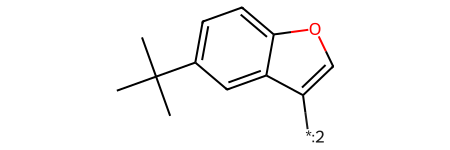

In [12]:
m = Chem.MolFromSmiles("CC(C)(C)c1ccc2occ([*:2])c2c1")
m

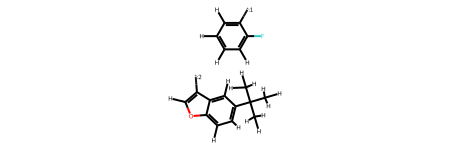

In [8]:
m2 = Chem.AddHs(m)
m2

[14:04:10] Molecule does not have explicit Hs. Consider calling AddHs()
[14:04:10] UFFTYPER: Unrecognized atom type: *_ (11)


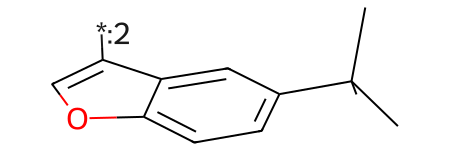

In [13]:
AllChem.EmbedMolecule(m)
m

In [14]:
m.GetNumConformers()

1

In [20]:
m.GetConformer().GetAtomPosition(0)

In [5]:
rotatable_bonds = Chem.rdMolDescriptors.CalcNumRotatableBonds(m2)
rotatable_bonds

3

In [6]:
# Setup the parameters for the embedding
params = getattr(rdDistGeom, "ETDG")()
params.randomSeed = 0
params.enforceChirality = True
params.useRandomCoords = True
params.numThreads = 1

In [7]:
# Embed conformers
confs = rdDistGeom.EmbedMultipleConfs(m2, numConfs=50, params=params)
len(confs)

50

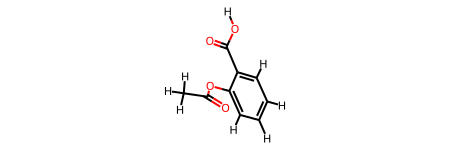

In [8]:
# Minimize energy
energy_iterations = 200
results = rdForceFieldHelpers.UFFOptimizeMoleculeConfs(m2, maxIters=energy_iterations)
energies = [energy for _, energy in results]
energies = []
for conf in m2.GetConformers():
    ff = rdForceFieldHelpers.UFFGetMoleculeForceField(m2, confId=conf.GetId())
    energies.append(ff.CalcEnergy())
energies = np.array(energies)
# Add the energy as a property to each conformer
[conf.SetDoubleProp("rdkit_uff_energy", energy) for energy, conf in zip(energies, m2.GetConformers())]

# Now we reorder conformers according to their energies,
# so the lowest energies conformers are first.
mol_clone = copy.deepcopy(m2)
ordered_conformers = [
    conf for _, conf in sorted(zip(energies, mol_clone.GetConformers()), key=lambda x: x[0])
]
m2.RemoveAllConformers()
[m2.AddConformer(conf, assignId=True) for conf in ordered_conformers]

# Align conformers to each other
rdMolAlign.AlignMolConformers(m2)
m2